In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import pickle
import math
import optuna
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import preprocessing
from NFLUtils import NFLUtils
nfl_utils = NFLUtils()

%matplotlib inline

# ANN
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

import logging
# Set up logging
logging.basicConfig(level=logging.INFO)
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# XGBoost 
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns # confusion matrix

# Set device to GPU if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def set_all_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Load CSV & UMAP model
cp Combined.csv ~/drive/Notes/ML/Pytorch/footballData/

In [3]:
# Load CSV
df = pd.read_csv("./footballData/CombinedSlidingWindow4.csv", index_col=False, low_memory=False)

df.info()

# The performance set's size is defined in the SlidingWindowNFL-1 file. When kick_punt_umap_dim_1 (or 2) is blank
test_performance_df = df[df['kick_punt_umap_dim_1'].isna()]
df = df[df['kick_punt_umap_dim_1'].isna() == False]
print(f'df after perf set removed: {df.shape}')
print(f'performance set size: {test_performance_df.shape}')

# Remove missing odds data (Ignore data with no odds?)
test_performance_df = test_performance_df[test_performance_df['D_start_odds'] != 0.0]

print(f'df after missing odds removed: {df.shape}')
print(f'df perf after missing odds removed: {test_performance_df.shape}')

# Load the UMAP
filename = "kick_punt_umap.sav"
umap_model = None
try:
    with open(filename, 'rb') as file:
        umap_model = pickle.load(file)
        print(type(umap_model))
except EOFError:
    print("The file is empty or corrupt. Please check its content.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5464 entries, 0 to 5463
Data columns (total 70 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               5464 non-null   int64  
 1   Season                   5464 non-null   int64  
 2   Date                     5464 non-null   object 
 3   Home_Team                5464 non-null   object 
 4   Visitor_Team             5464 non-null   object 
 5   H_halftime_odds          5464 non-null   float64
 6   V_halftime_odds          5464 non-null   float64
 7   H_start_odds             5464 non-null   float64
 8   V_start_odds             5464 non-null   float64
 9   H_Won                    5464 non-null   float64
 10  D_First_Downs            5464 non-null   float64
 11  D_Rush                   5464 non-null   float64
 12  D_Yds                    5464 non-null   float64
 13  D_TDs                    5464 non-null   float64
 14  D_Cmp                   

### Remove items w/ missing odds data, apply UMAP to performance set

In [4]:
# Remove missing odds data
test_performance_df = test_performance_df[test_performance_df['D_start_odds'] != 0.0]
print(test_performance_df.shape)

# ---- Apply UMAP to performance set ----
# Fit standardScaler on the training set
umap_columns = ["D_kick_punt_returns_lng", "D_kick_punt_returns_rt", "D_kick_punt_returns_yds"]
umap_train_df = df[umap_columns]
umap_scaler = StandardScaler().fit(umap_train_df)

# Scale the test set
scaled_return_game_df = umap_scaler.transform(test_performance_df[umap_columns])

if umap_model is None:
    print("UMAP not correctly loaded FIX NOW")

umap_embedding = umap_model.transform(scaled_return_game_df)
print(umap_embedding.shape)

# Create the two new columns, drop the 4
test_performance_df['kick_punt_umap_dim_1'] = umap_embedding[:,0]
test_performance_df['kick_punt_umap_dim_2'] = umap_embedding[:,1]

test_performance_df.drop(umap_columns, axis=1, inplace=True)
df.drop(umap_columns, axis=1, inplace=True)



(191, 70)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(191, 2)


In [5]:
test_performance_df[:5]
# print(test_performance_df['H_start_odds'][:5])
# print(test_performance_df['V_start_odds'][:5])

,Unnamed: 0,Season,Date,Home_Team,Visitor_Team,H_halftime_odds,V_halftime_odds,H_start_odds,V_start_odds,H_Won,D_First_Downs,D_Rush,D_Yds,D_TDs,D_Cmp,D_Att,D_Yd,D_TD,D_INT,D_Sacked,D_Sacked_Yards,D_Net_Pass_Yards,D_Total_Yards,D_Fumbles,D_Lost,D_Turnovers,D_Penalties,D_Third_Down_Conv,D_Fourth_Down_Conv,D_Time_of_Possession,D_passing_att,D_passing_cmp,D_passing_int,D_passing_lng,D_passing_sk,D_passing_td,D_receiving_lng,D_rushing_att,D_rushing_lng,D_rushing_td,D_rushing_yds,D_passing_rushing_td,D_def_interceptions_int,D_def_interceptions_td,D_def_interceptions_yds,D_fumbles_ff,D_fumbles_fr,D_fumbles_td,D_fumbles_yds,D_sk,D_tackles_ast,D_tackles_comb,D_tackles_solo,D_punting_pnt,D_punting_avg,D_scoring_fga,D_scoring_fgp,D_scoring_xpa,D_scoring_xpp,D_Final,D_Final_Allowed,D_start_odds,D_halftime_odds,D_datediff,D_pythagorean,kick_punt_umap_dim_1,kick_punt_umap_dim_2
5264,7449,2023,2024-01-21,KAN,BUF,2.386667,1.577778,2.073398,1.724771,1.0,-5.049,14.342,-4.790,-10.070,-1.931,-67.962,5.714,52.173,-0.224,3.239,1.041,-18.251,-53.359,-0.615,1.029,-0.423,-3.945,-13.555,27.766,-4.679,3.271,1.649,-0.306,0.766,0.376,-0.178,13.745,-10.854,-4.265,-0.947,-35.108,-1.125,-1.165,-0.193,-8.337,0.421,-0.257,0.277,25.928,0.859,-2.725,5.923,8.648,0.551,2.611,1.207,0.139,-1.272,-0.004,-5.790,-1.099,0.349,0.809,2.0,-0.073,-0.944908,9.706598
5265,7444,2023,2024-01-28,DET,SFO,1.263333,3.894444,4.307745,1.203585,0.0,-0.376,-5.287,1.664,-19.688,6.013,-10.797,3.569,26.740,-0.405,4.852,-0.741,15.220,-15.201,0.130,-0.277,-0.445,16.338,-14.753,38.606,-1.158,2.920,3.124,-0.397,-4.086,-0.315,-0.269,4.240,-1.072,-18.576,0.293,-30.421,0.024,-0.155,-0.104,0.189,0.511,-0.168,0.000,1.961,0.267,-2.540,-1.567,0.973,0.893,0.897,-0.082,0.198,-0.369,-0.064,-0.484,2.681,3.104,-2.631,-1.0,-0.178,4.765425,5.378789
5266,7445,2023,2024-01-28,KAN,BAL,1.345556,3.222222,2.885004,1.396731,1.0,-1.149,-29.932,-1.342,3.770,2.065,5.677,3.682,1.174,0.019,0.237,-6.887,15.044,-17.795,-0.440,0.002,0.246,1.906,-1.403,-7.241,0.512,7.909,4.222,0.376,-2.455,-0.990,-1.230,-16.767,-3.475,-19.850,-0.497,-32.839,-1.727,-0.833,-0.034,-13.352,-0.654,-0.109,0.207,14.747,0.109,-8.664,-8.438,0.226,-0.408,1.400,0.973,0.093,-1.516,-0.004,-8.754,-2.969,1.488,-1.877,-1.0,-0.126,0.746289,10.155971
5267,7645,2023,2024-02-11,SFO,KAN,1.301111,3.472222,1.757009,2.028809,0.0,1.930,23.153,3.614,-38.602,1.845,-27.846,2.388,45.530,0.263,-3.815,6.219,22.362,34.943,-0.535,-0.615,-0.271,-6.133,18.912,-20.599,2.204,-1.002,-0.423,0.194,6.831,0.779,0.370,3.113,1.567,2.206,0.951,12.581,1.320,1.064,0.080,13.771,-0.396,-0.668,-0.155,-14.084,-0.516,-2.174,-5.335,-3.160,0.132,-1.046,-1.315,-0.326,1.278,-0.052,3.839,3.252,-0.272,-2.171,0.0,0.104,6.982881,4.331357
5268,7808,2024,2024-10-10,SFO,SEA,1.056667,9.383333,1.461897,2.642566,1.0,-6.140,14.184,7.482,-32.831,-7.632,-101.676,-0.471,56.893,-1.129,-1.901,-3.625,-37.717,-7.982,1.507,0.691,-0.143,-21.287,6.148,1.838,0.993,-15.357,-12.401,-0.485,-3.408,-0.875,0.452,-3.691,10.496,-0.232,-1.471,29.735,-1.018,0.526,0.460,24.419,1.353,2.059,0.000,-0.919,0.618,-1.915,-3.603,-1.688,-1.445,-0.773,0.985,0.460,0.000,0.000,0.062,-6.312,-1.181,-8.327,0.0,0.026,-2.863090,8.433458


# Columns to use
(TODO)

## 1. Separate continuous, categorical, and label column names

Pretty much everything is continuous. 

Note: the y_col is what you're trying to predict

## Feature engineering
New Columns
- **h_win**: Home team won


In [6]:
cat_cols = []

cont_cols = [col for col in nfl_utils.cont_cols if col not in nfl_utils.drop_cols]


y_col = ['H_Won'] # Old
y_col = ['H_Won', 'H_start_odds', 'V_start_odds']
y_col_perf = ['H_Won', 'H_start_odds', 'V_start_odds', 'H_halftime_odds', 'V_halftime_odds']


# create cont_df and y_df from the df
print(df.shape)
cont_df = df[cont_cols]
y_df = df[y_col]

# test performance set
perf_conts_df = test_performance_df[cont_cols]
perf_y_df = test_performance_df[y_col_perf]
perf_date_df = test_performance_df[['Date','Home_Team', 'Visitor_Team']]

# print(cont_df.dtypes)
print(cont_df.shape)
print(perf_y_df.shape)
print(perf_y_df.tail())
# print(perf_conts_df.tail())


(5264, 67)
(5264, 48)
(191, 5)
      H_Won  H_start_odds  V_start_odds  H_halftime_odds  V_halftime_odds
5459    0.0      1.724771      2.073398              0.0              0.0
5460    0.0      4.991514      1.159063              0.0              0.0
5461    1.0      4.513858      1.188369              0.0              0.0
5462    0.0      3.804017      1.250000              0.0              0.0
5463    0.0      1.790476      1.986097              0.0              0.0


In [7]:
print(perf_y_df[:5])
cont_df[:5]

      H_Won  H_start_odds  V_start_odds  H_halftime_odds  V_halftime_odds
5264    1.0      2.073398      1.724771         2.386667         1.577778
5265    0.0      4.307745      1.203585         1.263333         3.894444
5266    1.0      2.885004      1.396731         1.345556         3.222222
5267    0.0      1.757009      2.028809         1.301111         3.472222
5268    1.0      1.461897      2.642566         1.056667         9.383333


,D_First_Downs,D_Rush,D_Yds,D_TDs,D_Cmp,D_Att,D_Yd,D_INT,D_Sacked,D_Sacked_Yards,D_Total_Yards,D_Fumbles,D_Lost,D_Turnovers,D_Penalties,D_Fourth_Down_Conv,D_Time_of_Possession,D_passing_att,D_passing_cmp,D_passing_int,D_passing_lng,D_passing_sk,D_passing_td,D_receiving_lng,D_rushing_att,D_rushing_lng,D_rushing_td,D_rushing_yds,D_def_interceptions_int,D_def_interceptions_td,D_def_interceptions_yds,D_fumbles_fr,D_fumbles_td,D_fumbles_yds,D_sk,D_tackles_ast,D_tackles_comb,D_tackles_solo,kick_punt_umap_dim_1,kick_punt_umap_dim_2,D_punting_pnt,D_punting_avg,D_scoring_fga,D_scoring_fgp,D_scoring_xpa,D_scoring_xpp,D_pythagorean,D_start_odds
0,2.265,5.140,-8.261,31.290,-8.121,43.430,4.074,-0.684,-0.044,-4.750,134.107,-0.342,-0.103,-1.526,22.515,35.846,-1.945,15.846,8.055,-1.257,34.941,-2.048,1.702,32.967,-6.551,24.316,-0.099,-11.221,0.180,0.276,10.643,-0.835,0.000,-4.599,0.526,0.0,0.0,0.0,5.291422,9.552850,0.599,-1.273,0.662,-0.094,2.044,0.441,0.114,1.181
1,-3.629,-29.721,-20.239,105.471,-4.695,135.596,-6.074,-0.011,-6.794,-1.007,-58.301,0.239,0.537,0.941,-2.555,13.787,-5.022,-2.121,1.048,1.272,19.176,1.702,0.835,7.434,-14.743,-19.537,-2.132,-82.452,-0.820,0.000,2.096,1.397,-0.165,-11.360,-1.272,0.0,0.0,0.0,7.618100,7.267665,-0.864,5.719,1.636,-0.153,-1.904,0.099,-0.063,1.330
2,2.647,-7.419,-4.353,41.000,3.283,62.070,-4.474,-0.184,-3.724,-4.224,65.592,-1.029,-0.110,-1.324,-13.379,13.787,-1.588,0.430,0.305,-0.460,2.772,-2.246,0.033,21.437,-3.029,10.765,-0.415,-4.886,-0.952,-0.165,-10.676,-0.140,-0.460,-21.176,-0.165,0.0,0.0,0.0,2.573103,1.891357,-0.989,-4.020,0.901,0.242,-1.007,-0.526,0.179,0.741
3,6.827,-3.625,2.011,-21.217,5.103,37.158,7.551,2.173,-2.059,-13.463,144.618,0.544,1.187,3.801,-11.202,49.173,5.379,14.000,10.915,3.441,21.096,-3.386,-0.460,47.860,-0.140,-5.044,1.118,-11.184,0.614,0.165,8.996,0.937,0.000,0.662,0.732,0.0,0.0,0.0,4.044179,8.739308,-4.794,-4.150,2.202,0.255,-0.390,-0.360,0.248,-5.646
4,3.110,-15.445,10.092,-12.125,-0.239,-82.890,1.221,0.368,-3.026,0.585,13.544,0.518,-0.544,-0.162,11.952,6.434,1.794,-8.794,-8.033,-0.360,-3.371,0.007,-1.228,-34.746,9.721,-6.382,0.754,40.412,-0.044,-0.276,-18.860,-1.121,0.276,1.985,-0.298,0.0,0.0,0.0,3.613956,2.804782,-1.349,-5.401,-0.890,0.103,-0.022,0.000,0.007,1.181


#### 1a. Normalize cont_df
StandardScaler is instead used by the pipeline

In [8]:
standard_scaler = preprocessing.StandardScaler()
cont_scaled = standard_scaler.fit_transform(cont_df.values)
cont_df = pd.DataFrame(cont_scaled)
# print(cont_df.head())

# test performance set
perf_conts_df_scaled = standard_scaler.fit_transform(perf_conts_df.values)
perf_conts_df = pd.DataFrame(perf_conts_df_scaled)

### 3. Create an array of continuous values
Numpy array 'conts' containing stack of each continuous column

In [9]:
conts = np.stack([cont_df[col].values for col in list(cont_df.columns)], 1)
conts[:5]

y_col = np.stack([y_df[col].values for col in y_col], 1)

# test performance set
perf_conts = np.stack([perf_conts_df[col].values for col in list(perf_conts_df.columns)], 1)
perf_y_col = np.stack([perf_y_df[col].values for col in list(perf_y_df.columns)], 1)
perf_date_col = np.stack([perf_date_df[col].values for col in list(perf_date_df.columns)], 1)


conts_train = conts
y_train = y_col

### 4. Convert conts to tensor

In [10]:
print(conts.shape)
print(y_col.shape)

(5264, 48)
(5264, 3)


In [11]:
# Handled by model.fit()
# conts = torch.tensor(conts, dtype=torch.float32)
# y_col = torch.tensor(y_col, dtype=torch.float32)


In [12]:
"""
Want: 
    An array > 1 elements for PCC formula
    A smaller array for kelly_criterion
    


x: 1d array of predictions between -1 and 1 where negative number means visitor predicted to win
y: ['H_Won', 'H_start_odds', 'V_start_odds']
pearson_multiplier: constant to multiply the pearson correlation coefficient's result by
max_bet_pct: max percentage allowed per bet.
return_res_array: Skip the torch.cumprod part
"""
def nfl_custom_criterion(x, y, pearson_multiplier=0.5, max_bet_pct=0.1, return_res_array=False):
    # ------------------------------------------------
    # Preliminary calculations
    # ------------------------------------------------
    # acct_value = 100 # Preset account value
    batch_size = len(x)
    h_start_odds = y[:,1]
    v_start_odds = y[:,2]
    h_won = y[:,0]
    y_decimal_odds = torch.where(x > 0, h_start_odds, v_start_odds) # Decimal odds for model's predicted outcome
    y_prob = 1 / y_decimal_odds                  # Implied Probability (regardless of correct prediction)
    x_H_Won = torch.round(torch.sigmoid(20 * x)) # H_won for predicted bets (Converts model's -1 to 1 range to 0 to 1)
                                                 # Sigmoid so that it's differentiable. The 20 is arbitrarily large number
    y_incorrect_prediction = torch.abs((x_H_Won - h_won))        # 1 if wrong bet, otherwise 0. Used to reset kelly when wrong
    y_incorrect_prediction_mult_two = 2 * y_incorrect_prediction   # 2 if wrong bet, 0 if correct

    #x = torch.abs(x)         # OLD VERSION
    x_prob = torch.where(x > 0, (x + 1) / 2, (1 - x) / 2)
    x = x_prob                # x is now the implied probability(?) of your prediction.
                              # It's a number between 0 and 1 (formerly -1 and 1) representing the model's predicted probability of a win.
                              # This now only shows the probability. Not whether it was correct & not for which side (home vs visitor)

    
    # ------------------------------------------------
    # 1. Calculate the Pearson Correlation Coefficient
    #    Currently includes cases where predicted wrong
    #    ^ This is filtered out after step 2
    # ------------------------------------------------
    n = x.size(0)
    sum_x = torch.sum(x)
    sum_x_squared = torch.sum(x**2)
    sum_y = torch.sum(y_prob)
    sum_y_squared = torch.sum(y_prob**2)
    sum_pow_x = torch.sum(x**2)
    sum_pow_y = torch.sum(y_prob**2)
    x_mul_y = torch.mul(x, y_prob)
    sum_x_mul_y = torch.sum(x_mul_y)

    
    # PCC Formula (eps to avoid NaN)
    eps = 1e-8
    pcc_numerator = n * sum_x_mul_y - sum_x * sum_y
    pcc_denominator_one = torch.sqrt(n * sum_pow_x - sum_x_squared + eps)
    pcc_denominator_two = torch.sqrt(n * sum_pow_y - sum_y_squared + eps)
    pcc = pcc_numerator / (pcc_denominator_one * pcc_denominator_two + eps)
    pcc = pearson_multiplier * torch.abs(pcc)

    
    # ------------------------------------------------
    # 2. Calculate the kelly criterion
    #    Entirely wrong predictions are negated and kept in "incorrect_bets" (pcc not applied to wrong predictions)
    #    Correct predictions are kept in "correct_bets". Pcc is applied to this & stored in pcc_adjusted_correct_bets
    #    Possible issue: This always bets max_bet_pct
    #    The result is cumulatively calculated. i.e. The sum of the previous values are used to calculate the next one
    # ------------------------------------------------
    # kelly_criterion = x - ((1 - x) / y_decimal_odds)  # OLD VERSION
    kelly_criterion = x - ((1 - x) / (y_decimal_odds - 1))
    bet_multiplier = torch.clamp(kelly_criterion, min=0)   # Kelly results that are negative are ignored
    bet_multiplier = bet_multiplier*max_bet_pct            # Scale down the bets to the maximum allowed percentage per bet


    # 4/5/25 adjustment of kelly
    #    Want to use cumprod. Cumsum does nothing and is the same as torch.sum in this scenario?
    #    Basically start with max_bet_pct and return as if you made the bets sequentially
    correct_bet_multiplier = bet_multiplier - (bet_multiplier * y_incorrect_prediction)          # Correct bets after kelly. Bet multiplier or 0
    correct_bet_multiplier = correct_bet_multiplier * (1 - pcc)                                  # "correct_bet_multiplier" penalized by pcc
    assert torch.all(correct_bet_multiplier <= max_bet_pct), "Correct bet mult. can't exceed max bet pct"

    correct_bet_multiplier = correct_bet_multiplier * y_decimal_odds                             # Bet multiplier taking market odds into account
    incorrect_bet_multiplier = bet_multiplier - (bet_multiplier * y_incorrect_prediction_mult_two) # Negative numbers are incorrect bets
    incorrect_bet_multiplier = torch.clamp(incorrect_bet_multiplier, max=0)                      # Restrict to 0 or negative
    combined_bet_multiplier = correct_bet_multiplier + incorrect_bet_multiplier                  # Combine correct & incorrect bet multipliers
    combined_bet_multiplier = combined_bet_multiplier + 1                                        # Converts to format friendly to cumprod
                                                                                                 # Ex: loss=-0.3, profit=0.3 --> loss=0.7, profit=1.3

    assert torch.all((x >= 0) & (x <= 1)), "Probabilities must be between 0 and 1"
    assert torch.all(y_decimal_odds > 1), "Decimal odds must be greater than 1"
    assert torch.all(kelly_criterion <= 1), "Kelly Criterion cannot be greater than 1"
    assert torch.all(incorrect_bet_multiplier >= -max_bet_pct), "Incorrect bet mult. can't exceed max bet pct"
    
    # ------------------------------------------------
    # Combine & Return
    #     Negate everything for Adam & optuna
    # ------------------------------------------------
    if return_res_array:
        return combined_bet_multiplier
        
    # Prepend max_bet_pct to the tensor before torch.cumprod
    res = torch.sum(combined_bet_multiplier) / batch_size
    # print(res)
    return -res

In [13]:
class TabularModelUpdated(nn.Module, BaseEstimator, RegressorMixin):
    def __init__(self, n_cont, out_sz, layer_shape, p=0.5, optimizer_class=torch.optim.Adam,
                 lr=0.001, confidence_threshold=0.1, batch_size=1000):
        super().__init__()
        # Model architecture params
        self.layer_shape = layer_shape
        self.batch_size = batch_size
        self.n_cont = n_cont
        self.out_sz = out_sz
        self.p = p
        self.lr = lr

        # Training params
        # self.criterion = criterion
        self.confidence_threshold = confidence_threshold
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Variable that holds the list of layers
        layerlist = []
        n_in = n_cont # no embed again
        # Iterate through the passed in "layers" parameter (ie, [200,100]) to build a list of layers
        for i, width in enumerate(self.layer_shape):
            # First layer gets special treatment
            if i == 0:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.Mish(),  # Mish instead of ReLU
                    nn.BatchNorm1d(width),
                    nn.Dropout(p/2)  # Less dropout in earlier layers
                ])
            else:
                layerlist.extend([
                    nn.Linear(n_in, width),
                    nn.Mish(),
                    nn.BatchNorm1d(width),
                    nn.Dropout(p)
                ])
            n_in = width
        # layerlist.append(nn.Linear(layers[-1], out_sz))
        
        # Final layer
        layerlist.extend([nn.Linear(self.layer_shape[-1], out_sz)])
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist).to(self.device)
        
        # Initialize the optimizer & scheduler
        self.optimizer = optimizer_class(self.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min',
                                                                    factor=0.1, patience=10,
                                                                    threshold=0.0001,threshold_mode='rel',
                                                                    cooldown=0, min_lr=0, eps=1e-08)
        
    def forward(self, x_cont):
        # x_cont = self.bn_cont(x_cont)  # Normalize the incoming continuous data
        x = self.layers(x_cont)        # Set up model layers
        return torch.clamp(x, -1, 1)
    
    def fit(self, X, y):
        """
        For sklearn pipeline
        """
        # Convert X,y to torch.tensor if needed
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X).to(self.device)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y).to(self.device)
        
        # Initialize optimizer
        # optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        # Verify optimizer exists
        if not hasattr(self, 'optimizer'):
            raise ValueError("Optimizer not initialized. Set self.optimizer in __init__.")

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        # Training loop
        running_loss = []    # This is only for training over final dataset
        self.train()
        for X_batch, y_batch in dataloader:
            self.optimizer.zero_grad()
            y_pred = self.forward(X_batch)[:,0]
            #loss = self.criterion(y_pred, y_batch)
            loss = nfl_custom_criterion(y_pred, y_batch)
            running_loss.append(loss)
            loss.backward()
            self.optimizer.step()
        # return self  # TODO: This being replaced w/ loss might break things
        return torch.mean(torch.stack(running_loss))

    def step_lr(self, val_loss):
        """
        Since CV is run outside of this class, we need to update the local self.optimizer variable
        after each CV fold.
        """
        self.scheduler.step(val_loss)
    
    def predict(self, X):
        self.eval()
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X).to(self.device)
        with torch.no_grad():
            y_pred = self(X).squeeze()
        return y_pred
        
    def score(self, X, y):
        """
        12/5 - this isn't called at all if 'scoring' is defined
        """
        self.eval()
    
        if not isinstance(X, torch.Tensor):
            X = torch.FloatTensor(X)
        if not isinstance(y, torch.Tensor):
            y = torch.FloatTensor(y)
    
        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
    
        total_loss = 0.0
        count = 0
    
        with torch.no_grad():
            for X_batch, y_batch in dataloader:
                y_pred = self.forward(X_batch)[:, 0]  # [batch_size]
                batch_loss = nfl_custom_criterion(y_pred, y_batch)  # scalar
                total_loss += batch_loss.item() * len(X_batch)
                count += len(X_batch)
    
        return total_loss / count

In [14]:
def objective(trial, override_params=None):
    """
    When doing optuna training: trial is defined, override_params left as None
    when recreating model using best parameters (override_params): trial is None, override_params are defined
    """
    is_training = trial != None
    # --- Suggest hyperparameters ---
    # criterion = trial.suggest_categorical('criterion', nfl_utils.map_losses(None).keys())
    if is_training:
        batch_size = trial.suggest_categorical('batch_size', [100, 400, 1000, 3000])
        first_layer_size = trial.suggest_categorical('first_layer_size', [64, 56, 48, 32, 16, 12])
        min_layers = math.floor(math.sqrt(first_layer_size))
        num_layers = trial.suggest_int('num_layers', 2, min_layers)
        confidence_threshold = trial.suggest_float('confidence_threshold', 0, 0.05)
        dropout = trial.suggest_float('dropout', 0.28, 0.38)
        lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
    else:
        batch_size = override_params["batch_size"]
        first_layer_size = override_params["first_layer_size"]
        num_layers = override_params["num_layers"]
        confidence_threshold = override_params["confidence_threshold"]
        dropout = override_params["dropout"]
        lr = override_params["lr"]
    
    layer_shape = [first_layer_size]
    for i in range(1, num_layers):
        layer_shape.append(first_layer_size//(2*i))

    # Set random state to have consistent results (42 is arbitrary)
    set_all_seeds()
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=False)

    # Split once
    X_train_fold = []
    X_val = []
    y_train_fold = []
    y_val = []
    models = []
    for train_index, val_index in kf.split(conts_train):
        # print(f"train {train_index.shape} val {val_index.shape}")
        X_train_fold.append(torch.FloatTensor(conts_train[train_index]).to(device))
        X_val.append(torch.FloatTensor(conts_train[val_index]).to(device))

        y_train_fold.append(torch.FloatTensor(y_train[train_index]).to(device))
        y_val.append(torch.FloatTensor(y_train[val_index]).to(device))

        model = TabularModelUpdated(
            n_cont=conts.shape[1],
            out_sz=1,
            layer_shape=layer_shape,
            p=dropout,     # Dropout
            # criterion=nfl_utils.map_losses(criterion),
            optimizer_class=torch.optim.Adam,
            lr=lr,   # Learning rate 
            confidence_threshold=confidence_threshold,
            batch_size=batch_size
        )
        models.append(model)

    # If not training, ignore CV
    if is_training is False:
        # put everything in one fold to ignore CV
        n_splits = 1 
        X_train_fold.append(torch.FloatTensor(conts_train).to(device))
        y_train_fold.append(torch.FloatTensor(y_train).to(device))
        # X_val & y_val is not used since we train on whole dataset
    
    # Run once on each split, track average loss, stop if > max patience
    max_patience = 10
    current_patience = max_patience
    tracked_loss = 0.0
    n_epochs = 0
    while current_patience > 0 or n_epochs < 10:
        n_epochs = n_epochs + 1
        running_loss = []
        for i in range(0,n_splits):
            # ----- Train -----
            model_score = models[i].fit(X_train_fold[i], y_train_fold[i])

            # ----- Eval -----
            # print(f"los: {models[i].score(X_val[i], y_val[i])} type: {type(models[i].score(X_val[i], y_val[i]))}")
            if is_training:
                model_score = models[i].score(X_val[i], y_val[i])
            else:
                model_score = model_score.detach().numpy()
            running_loss.append(model_score)
            models[i].step_lr(model_score)

        # print(f"{running_loss} at {n_epochs}")
        running_loss = np.mean(running_loss)
        # print(f"rloss: {running_loss}")
        
        # ----- Current epoch loss < previous -----
        # print(f"{tracked_loss} {running_loss} {tracked_loss > running_loss}")
        if tracked_loss > running_loss:
            current_patience = max_patience
            tracked_loss = running_loss
        else:
            current_patience = current_patience - 1

    # Return the tracked_loss if in optuna training (trial != None)
    if is_training:
        trial.suggest_int('n_epochs', n_epochs, n_epochs)
        trial.report(tracked_loss, n_epochs)
        return tracked_loss

    # When not training, only the first model is relevant since CV is ignored
    return models[0]

def print_callback(study, trial):
    print(f"Trial {trial.number} finished with value: {trial.value}")
    print(f"Best trial so far: {study.best_trial.number}, value: {study.best_trial.value}")

In [16]:
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=1000
    )
)
# Uncomment to run
if True:
    study.optimize(objective, n_trials=200, callbacks=[print_callback])
    # study.optimize(objective, n_trials=3)
    print("Best trial:")
    trial = study.best_trial
    print("Value: ", trial.value)
    print("Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2025-04-06 18:55:32,008] A new study created in memory with name: no-name-b709aa54-e381-4779-8754-7aa1f6a8f509
[I 2025-04-06 18:55:49,152] Trial 0 finished with value: -4694399267.05 and parameters: {'batch_size': 3000, 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.012322704464725331, 'dropout': 0.31378484943835805, 'lr': 0.0010881917656910436, 'n_epochs': 50}. Best is trial 0 with value: -4694399267.05.


Trial 0 finished with value: -4694399267.05
Best trial so far: 0, value: -4694399267.05


[I 2025-04-06 18:56:06,517] Trial 1 finished with value: -32507704505.6 and parameters: {'batch_size': 3000, 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.041285346202836776, 'dropout': 0.3256359987731165, 'lr': 0.008882004305843943, 'n_epochs': 50}. Best is trial 1 with value: -32507704505.6.


Trial 1 finished with value: -32507704505.6
Best trial so far: 1, value: -32507704505.6


[I 2025-04-06 18:56:28,363] Trial 2 finished with value: -854077632614.4 and parameters: {'batch_size': 1000, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.012325799612466388, 'dropout': 0.2987029276483133, 'lr': 0.001082159228741394, 'n_epochs': 50}. Best is trial 2 with value: -854077632614.4.


Trial 2 finished with value: -854077632614.4
Best trial so far: 2, value: -854077632614.4


[I 2025-04-06 18:56:48,175] Trial 3 finished with value: -3013567066784.0 and parameters: {'batch_size': 1000, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.0065760206336920425, 'dropout': 0.31278221325016364, 'lr': 0.0012913983048685829, 'n_epochs': 53}. Best is trial 3 with value: -3013567066784.0.


Trial 3 finished with value: -3013567066784.0
Best trial so far: 3, value: -3013567066784.0


[I 2025-04-06 18:57:07,627] Trial 4 finished with value: -5377212505.6 and parameters: {'batch_size': 3000, 'first_layer_size': 32, 'num_layers': 3, 'confidence_threshold': 0.0044355870831241815, 'dropout': 0.29480154457335517, 'lr': 0.0056694584421884565, 'n_epochs': 50}. Best is trial 3 with value: -3013567066784.0.


Trial 4 finished with value: -5377212505.6
Best trial so far: 3, value: -3013567066784.0


[I 2025-04-06 18:58:10,376] Trial 5 finished with value: -4566659977625.6 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 2, 'confidence_threshold': 0.01871844651907653, 'dropout': 0.3446119963864044, 'lr': 0.001539335558041041, 'n_epochs': 50}. Best is trial 5 with value: -4566659977625.6.


Trial 5 finished with value: -4566659977625.6
Best trial so far: 5, value: -4566659977625.6


[I 2025-04-06 18:59:03,124] Trial 6 finished with value: -56145887413990.4 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03432279414425307, 'dropout': 0.3549338686656503, 'lr': 0.0017244785989805071, 'n_epochs': 50}. Best is trial 6 with value: -56145887413990.4.


Trial 6 finished with value: -56145887413990.4
Best trial so far: 6, value: -56145887413990.4


[I 2025-04-06 18:59:29,117] Trial 7 finished with value: -4606397839667.2 and parameters: {'batch_size': 1000, 'first_layer_size': 48, 'num_layers': 3, 'confidence_threshold': 0.03363255622697286, 'dropout': 0.35797188419311854, 'lr': 0.002642987505712631, 'n_epochs': 50}. Best is trial 6 with value: -56145887413990.4.


Trial 7 finished with value: -4606397839667.2
Best trial so far: 6, value: -56145887413990.4


[I 2025-04-06 19:00:34,736] Trial 8 finished with value: -82144354242150.4 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 2, 'confidence_threshold': 0.011788348951225332, 'dropout': 0.3474735025410615, 'lr': 0.004629850515195867, 'n_epochs': 53}. Best is trial 8 with value: -82144354242150.4.


Trial 8 finished with value: -82144354242150.4
Best trial so far: 8, value: -82144354242150.4


[I 2025-04-06 19:01:44,231] Trial 9 finished with value: -10910806813286.4 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 4, 'confidence_threshold': 0.0054097877012570465, 'dropout': 0.3705059063352554, 'lr': 0.001694389556479787, 'n_epochs': 50}. Best is trial 8 with value: -82144354242150.4.


Trial 9 finished with value: -10910806813286.4
Best trial so far: 8, value: -82144354242150.4


[I 2025-04-06 19:02:30,506] Trial 10 finished with value: -7599564202639.0 and parameters: {'batch_size': 400, 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.02337699801505614, 'dropout': 0.37605859888453924, 'lr': 0.0041852649911817705, 'n_epochs': 50}. Best is trial 8 with value: -82144354242150.4.


Trial 10 finished with value: -7599564202639.0
Best trial so far: 8, value: -82144354242150.4


[I 2025-04-06 19:03:24,903] Trial 11 finished with value: -53433482702336.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03294101724296215, 'dropout': 0.3436333749047128, 'lr': 0.0027619306546269153, 'n_epochs': 50}. Best is trial 8 with value: -82144354242150.4.


Trial 11 finished with value: -53433482702336.0
Best trial so far: 8, value: -82144354242150.4


[I 2025-04-06 19:04:20,368] Trial 12 finished with value: -119593241898227.2 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04845303251283521, 'dropout': 0.35381437104402846, 'lr': 0.0021938890949077068, 'n_epochs': 50}. Best is trial 12 with value: -119593241898227.2.


Trial 12 finished with value: -119593241898227.2
Best trial so far: 12, value: -119593241898227.2


[I 2025-04-06 19:05:15,864] Trial 13 finished with value: -312696823790336.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.048900644353775405, 'dropout': 0.33920262467053125, 'lr': 0.0041248408419029565, 'n_epochs': 50}. Best is trial 13 with value: -312696823790336.0.


Trial 13 finished with value: -312696823790336.0
Best trial so far: 13, value: -312696823790336.0


[I 2025-04-06 19:05:42,322] Trial 14 finished with value: -2246312907069.831 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.049579531773586386, 'dropout': 0.3297442240019445, 'lr': 0.0021251487068006778, 'n_epochs': 50}. Best is trial 13 with value: -312696823790336.0.


Trial 14 finished with value: -2246312907069.831
Best trial so far: 13, value: -312696823790336.0


[I 2025-04-06 19:06:43,759] Trial 15 finished with value: -177134286323712.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.049037998187856514, 'dropout': 0.28042611501320835, 'lr': 0.0037748035067084384, 'n_epochs': 54}. Best is trial 13 with value: -312696823790336.0.


Trial 15 finished with value: -177134286323712.0
Best trial so far: 13, value: -312696823790336.0


[I 2025-04-06 19:07:43,488] Trial 16 finished with value: -670441396106035.2 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04202338126682067, 'dropout': 0.2825528343331923, 'lr': 0.006945491821611467, 'n_epochs': 50}. Best is trial 16 with value: -670441396106035.2.


Trial 16 finished with value: -670441396106035.2
Best trial so far: 16, value: -670441396106035.2


[I 2025-04-06 19:10:12,092] Trial 17 finished with value: -181632670341529.6 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.041323752617251935, 'dropout': 0.2830111640747521, 'lr': 0.007330065200271172, 'n_epochs': 69}. Best is trial 16 with value: -670441396106035.2.


Trial 17 finished with value: -181632670341529.6
Best trial so far: 16, value: -670441396106035.2


[I 2025-04-06 19:11:02,745] Trial 18 finished with value: -12642519062399.65 and parameters: {'batch_size': 400, 'first_layer_size': 64, 'num_layers': 8, 'confidence_threshold': 0.04205646596380671, 'dropout': 0.32009379872478394, 'lr': 0.006726519280437443, 'n_epochs': 50}. Best is trial 16 with value: -670441396106035.2.


Trial 18 finished with value: -12642519062399.65
Best trial so far: 16, value: -670441396106035.2


[I 2025-04-06 19:12:00,401] Trial 19 finished with value: -54379964448768.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.027188523375366376, 'dropout': 0.33528113899954887, 'lr': 0.009178859224208292, 'n_epochs': 50}. Best is trial 16 with value: -670441396106035.2.


Trial 19 finished with value: -54379964448768.0
Best trial so far: 16, value: -670441396106035.2


[I 2025-04-06 19:12:57,874] Trial 20 finished with value: -53664633087590.4 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04429143495343815, 'dropout': 0.303528790470756, 'lr': 0.005271443219224218, 'n_epochs': 50}. Best is trial 16 with value: -670441396106035.2.


Trial 20 finished with value: -53664633087590.4
Best trial so far: 16, value: -670441396106035.2


[I 2025-04-06 19:14:45,010] Trial 21 finished with value: -7763027724288.0 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.03697167640555309, 'dropout': 0.2853097568366426, 'lr': 0.007056188312389713, 'n_epochs': 50}. Best is trial 16 with value: -670441396106035.2.


Trial 21 finished with value: -7763027724288.0
Best trial so far: 16, value: -670441396106035.2


[I 2025-04-06 19:16:42,155] Trial 22 finished with value: -994001796960256.0 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.03846293443448438, 'dropout': 0.2902778009435907, 'lr': 0.00712625667501608, 'n_epochs': 60}. Best is trial 22 with value: -994001796960256.0.


Trial 22 finished with value: -994001796960256.0
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:18:24,691] Trial 23 finished with value: -22633728628080.2 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.04526487625056581, 'dropout': 0.2961413337302844, 'lr': 0.003585604163694455, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 23 finished with value: -22633728628080.2
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:20:12,664] Trial 24 finished with value: -33257773966794.46 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.03794614876147974, 'dropout': 0.28928384414970154, 'lr': 0.0054394226898190805, 'n_epochs': 55}. Best is trial 22 with value: -994001796960256.0.


Trial 24 finished with value: -33257773966794.46
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:21:09,788] Trial 25 finished with value: -155960006843340.8 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.029618958251356287, 'dropout': 0.30580381013616065, 'lr': 0.007688608723561184, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 25 finished with value: -155960006843340.8
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:21:36,418] Trial 26 finished with value: -3011310638694.4 and parameters: {'batch_size': 1000, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.04496019675141039, 'dropout': 0.31861704092876353, 'lr': 0.009995983435537531, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 26 finished with value: -3011310638694.4
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:22:22,691] Trial 27 finished with value: -247768935286381.5 and parameters: {'batch_size': 400, 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.0372512022596287, 'dropout': 0.2890938232601704, 'lr': 0.006133973919766322, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 27 finished with value: -247768935286381.5
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:22:54,010] Trial 28 finished with value: -271605405113.6 and parameters: {'batch_size': 3000, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.02283067677452125, 'dropout': 0.33612268406958484, 'lr': 0.004529058409253121, 'n_epochs': 57}. Best is trial 22 with value: -994001796960256.0.


Trial 28 finished with value: -271605405113.6
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:23:18,040] Trial 29 finished with value: -4313995849.6 and parameters: {'batch_size': 3000, 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.03940278771628343, 'dropout': 0.30891920654400634, 'lr': 0.003215794397554204, 'n_epochs': 56}. Best is trial 22 with value: -994001796960256.0.


Trial 29 finished with value: -4313995849.6
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:24:15,435] Trial 30 finished with value: -36576082285977.6 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04601911282630488, 'dropout': 0.31898197331109995, 'lr': 0.008421172802682805, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 30 finished with value: -36576082285977.6
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:25:02,456] Trial 31 finished with value: -35247678218987.65 and parameters: {'batch_size': 400, 'first_layer_size': 64, 'num_layers': 6, 'confidence_threshold': 0.030366806177438203, 'dropout': 0.29233808214402673, 'lr': 0.005738076888396547, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 31 finished with value: -35247678218987.65
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:25:51,679] Trial 32 finished with value: -3391687322634.293 and parameters: {'batch_size': 400, 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.036489259355575884, 'dropout': 0.2868023617576026, 'lr': 0.006325828031402584, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 32 finished with value: -3391687322634.293
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:26:39,388] Trial 33 finished with value: -650955949754.8031 and parameters: {'batch_size': 400, 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.04071375930071741, 'dropout': 0.3042980974891955, 'lr': 0.004657537270494265, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 33 finished with value: -650955949754.8031
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:27:13,384] Trial 34 finished with value: -2657528125657.6 and parameters: {'batch_size': 400, 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.04279279563035359, 'dropout': 0.29901100051980656, 'lr': 0.007830374159253322, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 34 finished with value: -2657528125657.6
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:27:50,319] Trial 35 finished with value: -141803008510.0 and parameters: {'batch_size': 3000, 'first_layer_size': 64, 'num_layers': 4, 'confidence_threshold': 0.04679592106777457, 'dropout': 0.29046759458915117, 'lr': 0.006136621252791003, 'n_epochs': 58}. Best is trial 22 with value: -994001796960256.0.


Trial 35 finished with value: -141803008510.0
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:28:13,963] Trial 36 finished with value: -3504547596329.2 and parameters: {'batch_size': 1000, 'first_layer_size': 32, 'num_layers': 3, 'confidence_threshold': 0.03621698230533053, 'dropout': 0.2992691614203966, 'lr': 0.005305157417022689, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 36 finished with value: -3504547596329.2
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:29:02,291] Trial 37 finished with value: -12307017779827.432 and parameters: {'batch_size': 400, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.030129884062672196, 'dropout': 0.3133359622651886, 'lr': 0.003952589414541509, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 37 finished with value: -12307017779827.432
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:30:01,243] Trial 38 finished with value: -110194478600908.8 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03835981097874043, 'dropout': 0.3263625823599127, 'lr': 0.004997858140858983, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 38 finished with value: -110194478600908.8
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:30:27,704] Trial 39 finished with value: -606805933715.2 and parameters: {'batch_size': 1000, 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.017686922971686107, 'dropout': 0.28000080737052285, 'lr': 0.006383332490162863, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 39 finished with value: -606805933715.2
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:31:00,143] Trial 40 finished with value: -180055222265.6 and parameters: {'batch_size': 3000, 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.043536829329089324, 'dropout': 0.3372554804092889, 'lr': 0.00846243145977752, 'n_epochs': 65}. Best is trial 22 with value: -994001796960256.0.


Trial 40 finished with value: -180055222265.6
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:32:55,675] Trial 41 finished with value: -158673815479910.4 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.04084918989016517, 'dropout': 0.2841172648342286, 'lr': 0.007168194414686637, 'n_epochs': 50}. Best is trial 22 with value: -994001796960256.0.


Trial 41 finished with value: -158673815479910.4
Best trial so far: 22, value: -994001796960256.0


[I 2025-04-06 19:34:44,842] Trial 42 finished with value: -1095218897586585.6 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.040564642834425686, 'dropout': 0.2929450421814862, 'lr': 0.007402541258339619, 'n_epochs': 50}. Best is trial 42 with value: -1095218897586585.6.


Trial 42 finished with value: -1095218897586585.6
Best trial so far: 42, value: -1095218897586585.6


[I 2025-04-06 19:36:30,712] Trial 43 finished with value: -196079317636864.0 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.03398031847561013, 'dropout': 0.29280115663102757, 'lr': 0.00981295374060244, 'n_epochs': 50}. Best is trial 42 with value: -1095218897586585.6.


Trial 43 finished with value: -196079317636864.0
Best trial so far: 42, value: -1095218897586585.6


[I 2025-04-06 19:38:16,186] Trial 44 finished with value: -114435520098508.8 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.04731495230396218, 'dropout': 0.36342950240753213, 'lr': 0.005958478896733804, 'n_epochs': 50}. Best is trial 42 with value: -1095218897586585.6.


Trial 44 finished with value: -114435520098508.8
Best trial so far: 42, value: -1095218897586585.6


[I 2025-04-06 19:39:28,806] Trial 45 finished with value: -65451341534604.8 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.0016014459864025152, 'dropout': 0.2972125420042812, 'lr': 0.0011769792950032353, 'n_epochs': 50}. Best is trial 42 with value: -1095218897586585.6.


Trial 45 finished with value: -65451341534604.8
Best trial so far: 42, value: -1095218897586585.6


[I 2025-04-06 19:41:20,688] Trial 46 finished with value: -3445662457491.2 and parameters: {'batch_size': 100, 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.03273726064866342, 'dropout': 0.2886932061285993, 'lr': 0.00837185600443397, 'n_epochs': 50}. Best is trial 42 with value: -1095218897586585.6.


Trial 46 finished with value: -3445662457491.2
Best trial so far: 42, value: -1095218897586585.6


[I 2025-04-06 19:42:17,228] Trial 47 finished with value: -112761698104934.4 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03901534331373824, 'dropout': 0.3487799023215197, 'lr': 0.006740415561905032, 'n_epochs': 50}. Best is trial 42 with value: -1095218897586585.6.


Trial 47 finished with value: -112761698104934.4
Best trial so far: 42, value: -1095218897586585.6


[I 2025-04-06 19:42:57,686] Trial 48 finished with value: -15185023367521.6 and parameters: {'batch_size': 400, 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.035628423500812904, 'dropout': 0.3009959467081961, 'lr': 0.003357297077875375, 'n_epochs': 50}. Best is trial 42 with value: -1095218897586585.6.


Trial 48 finished with value: -15185023367521.6
Best trial so far: 42, value: -1095218897586585.6


[I 2025-04-06 19:43:52,757] Trial 49 finished with value: -26156865340416.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04759528690962961, 'dropout': 0.29455341588942835, 'lr': 0.002700923676270975, 'n_epochs': 50}. Best is trial 42 with value: -1095218897586585.6.


Trial 49 finished with value: -26156865340416.0
Best trial so far: 42, value: -1095218897586585.6


[I 2025-04-06 19:44:25,383] Trial 50 finished with value: -15304578191101.4 and parameters: {'batch_size': 1000, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.049797504251247376, 'dropout': 0.3095679090394514, 'lr': 0.004429240875965347, 'n_epochs': 50}. Best is trial 42 with value: -1095218897586585.6.


Trial 50 finished with value: -15304578191101.4
Best trial so far: 42, value: -1095218897586585.6


[I 2025-04-06 19:46:23,480] Trial 51 finished with value: -1271291448616550.5 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.03465028129956627, 'dropout': 0.29249556069963106, 'lr': 0.009964492443019689, 'n_epochs': 57}. Best is trial 51 with value: -1271291448616550.5.


Trial 51 finished with value: -1271291448616550.5
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 19:48:29,497] Trial 52 finished with value: -118778661339136.0 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.040458359985096004, 'dropout': 0.2847345318518357, 'lr': 0.007842610114495038, 'n_epochs': 59}. Best is trial 51 with value: -1271291448616550.5.


Trial 52 finished with value: -118778661339136.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 19:50:50,869] Trial 53 finished with value: -86482037426862.03 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.03235752085524097, 'dropout': 0.340019713067111, 'lr': 0.009391229030087501, 'n_epochs': 66}. Best is trial 51 with value: -1271291448616550.5.


Trial 53 finished with value: -86482037426862.03
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 19:52:55,433] Trial 54 finished with value: -177371421274931.2 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.043588502627579066, 'dropout': 0.28940422409942756, 'lr': 0.008573362771860403, 'n_epochs': 56}. Best is trial 51 with value: -1271291448616550.5.


Trial 54 finished with value: -177371421274931.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 19:53:58,130] Trial 55 finished with value: -126976837121843.2 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04259812408682679, 'dropout': 0.2800979995030014, 'lr': 0.007395423635922674, 'n_epochs': 54}. Best is trial 51 with value: -1271291448616550.5.


Trial 55 finished with value: -126976837121843.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 19:55:36,636] Trial 56 finished with value: -301723653168691.2 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.034922520242625446, 'dropout': 0.29448490939380356, 'lr': 0.004934060882877377, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 56 finished with value: -301723653168691.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 19:57:12,722] Trial 57 finished with value: -107905393031372.8 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.026775119226835335, 'dropout': 0.2956174273819975, 'lr': 0.004979428439851257, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 57 finished with value: -107905393031372.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 19:58:40,658] Trial 58 finished with value: -49786346582732.8 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 4, 'confidence_threshold': 0.031629385200877776, 'dropout': 0.33175858173613937, 'lr': 0.003993080542988686, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 58 finished with value: -49786346582732.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:00:20,579] Trial 59 finished with value: -66755864283123.2 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.027411610400160085, 'dropout': 0.3014360322487837, 'lr': 0.003563733613209977, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 59 finished with value: -66755864283123.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:01:53,015] Trial 60 finished with value: -8573541509644.8 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.03433834486785106, 'dropout': 0.3234425470999295, 'lr': 0.0024036317469622527, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 60 finished with value: -8573541509644.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:02:58,134] Trial 61 finished with value: -717139390059481.6 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.035163691121561924, 'dropout': 0.28736049812818343, 'lr': 0.006568214754930128, 'n_epochs': 59}. Best is trial 51 with value: -1271291448616550.5.


Trial 61 finished with value: -717139390059481.6
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:03:52,808] Trial 62 finished with value: -309025012229690.4 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.034998526241164424, 'dropout': 0.2849384205287043, 'lr': 0.0066385581472873725, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 62 finished with value: -309025012229690.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:04:49,302] Trial 63 finished with value: -89307150943846.4 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03958464358280097, 'dropout': 0.2833147047565284, 'lr': 0.006768383082531698, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 63 finished with value: -89307150943846.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:05:46,861] Trial 64 finished with value: -31723373637760.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04458642834930782, 'dropout': 0.2857985575903807, 'lr': 0.009086037679064322, 'n_epochs': 53}. Best is trial 51 with value: -1271291448616550.5.


Trial 64 finished with value: -31723373637760.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:06:50,804] Trial 65 finished with value: -46074813420467.2 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.009636033401880711, 'dropout': 0.29062157635365293, 'lr': 0.005595206642700387, 'n_epochs': 59}. Best is trial 51 with value: -1271291448616550.5.


Trial 65 finished with value: -46074813420467.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:07:45,078] Trial 66 finished with value: -136904097329766.4 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.037993481737613924, 'dropout': 0.28666797196605176, 'lr': 0.007690770599447193, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 66 finished with value: -136904097329766.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:08:38,790] Trial 67 finished with value: -60358005837004.8 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04242311428340243, 'dropout': 0.3071732901407716, 'lr': 0.0067204890995242106, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 67 finished with value: -60358005837004.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:09:33,089] Trial 68 finished with value: -152980607406387.2 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.021011883419404707, 'dropout': 0.28219530161464246, 'lr': 0.007976302303548764, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 68 finished with value: -152980607406387.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:09:52,095] Trial 69 finished with value: -2161205094.2 and parameters: {'batch_size': 3000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.031331230386520206, 'dropout': 0.34314092061823365, 'lr': 0.0018751859565639658, 'n_epochs': 52}. Best is trial 51 with value: -1271291448616550.5.


Trial 69 finished with value: -2161205094.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:10:46,318] Trial 70 finished with value: -52344603119616.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.045912254982854644, 'dropout': 0.2925331114372431, 'lr': 0.002921120315718948, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 70 finished with value: -52344603119616.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:12:02,437] Trial 71 finished with value: -34671687152742.4 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 3, 'confidence_threshold': 0.03516052567496809, 'dropout': 0.29423640642307974, 'lr': 0.004803657172229916, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 71 finished with value: -34671687152742.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:13:02,294] Trial 72 finished with value: -102613860696064.0 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.03546476647540612, 'dropout': 0.2866369945271992, 'lr': 0.005739143123744825, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 72 finished with value: -102613860696064.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:14:06,809] Trial 73 finished with value: -94446730028953.6 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 3, 'confidence_threshold': 0.03741398570876246, 'dropout': 0.3797069377091044, 'lr': 0.006442585563146517, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 73 finished with value: -94446730028953.6
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:15:14,890] Trial 74 finished with value: -245798977486182.4 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.029277624732664174, 'dropout': 0.2979689504552286, 'lr': 0.007176416284094235, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 74 finished with value: -245798977486182.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:16:59,047] Trial 75 finished with value: -112032504184348.8 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.033555074272450906, 'dropout': 0.3027904518343116, 'lr': 0.004292190546689166, 'n_epochs': 53}. Best is trial 51 with value: -1271291448616550.5.


Trial 75 finished with value: -112032504184348.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:17:19,358] Trial 76 finished with value: -1101473639891.8562 and parameters: {'batch_size': 1000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.039875375695566595, 'dropout': 0.29127604449241057, 'lr': 0.005365124061528609, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 76 finished with value: -1101473639891.8562
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:19:07,919] Trial 77 finished with value: -779581851685888.0 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.036490133500936245, 'dropout': 0.28261584205995033, 'lr': 0.005982740177438876, 'n_epochs': 60}. Best is trial 51 with value: -1271291448616550.5.


Trial 77 finished with value: -779581851685888.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:20:01,076] Trial 78 finished with value: -995899984208332.8 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03701357292894247, 'dropout': 0.2825009355002688, 'lr': 0.006002202455115294, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 78 finished with value: -995899984208332.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:21:14,893] Trial 79 finished with value: -8103316900979.2 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 3, 'confidence_threshold': 0.0416281731429046, 'dropout': 0.2822723302448261, 'lr': 0.0059092105651133466, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 79 finished with value: -8103316900979.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:21:34,267] Trial 80 finished with value: -4282718021.2 and parameters: {'batch_size': 3000, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03706896546370111, 'dropout': 0.28794586372298586, 'lr': 0.008137263719857029, 'n_epochs': 52}. Best is trial 51 with value: -1271291448616550.5.


Trial 80 finished with value: -4282718021.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:22:27,536] Trial 81 finished with value: -222329527185408.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03888895255585152, 'dropout': 0.2830567693933824, 'lr': 0.006957903948722735, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 81 finished with value: -222329527185408.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:23:22,335] Trial 82 finished with value: -381451729074071.7 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03632172718401159, 'dropout': 0.2853277478205278, 'lr': 0.006431737301318864, 'n_epochs': 52}. Best is trial 51 with value: -1271291448616550.5.


Trial 82 finished with value: -381451729074071.7
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:24:14,849] Trial 83 finished with value: -70352110208704.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03674569486451622, 'dropout': 0.2802106742904133, 'lr': 0.006173210634506798, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 83 finished with value: -70352110208704.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:25:07,456] Trial 84 finished with value: -169927767285350.4 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.041034118315769634, 'dropout': 0.3500553298868954, 'lr': 0.007486580522688814, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 84 finished with value: -169927767285350.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:26:00,715] Trial 85 finished with value: -312788611883678.4 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.03844645408598479, 'dropout': 0.2887030274631927, 'lr': 0.008867323067334256, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 85 finished with value: -312788611883678.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:27:02,912] Trial 86 finished with value: -243275155245286.4 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.03888794056015962, 'dropout': 0.28892002113312215, 'lr': 0.00881615113352306, 'n_epochs': 58}. Best is trial 51 with value: -1271291448616550.5.


Trial 86 finished with value: -243275155245286.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:27:55,510] Trial 87 finished with value: -45445278153932.8 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.03323358237805603, 'dropout': 0.28705340969007476, 'lr': 0.009865190477400842, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 87 finished with value: -45445278153932.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:28:48,455] Trial 88 finished with value: -307878327589171.2 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.03649756124757859, 'dropout': 0.29182120076649326, 'lr': 0.009354763964987148, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 88 finished with value: -307878327589171.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:29:08,155] Trial 89 finished with value: -245244339866.98438 and parameters: {'batch_size': 1000, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.038161156119597875, 'dropout': 0.28273591107623075, 'lr': 0.00899047964882979, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 89 finished with value: -245244339866.98438
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:30:18,832] Trial 90 finished with value: -342547457236428.8 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.02873472670527777, 'dropout': 0.29695305032780156, 'lr': 0.008138411136904057, 'n_epochs': 51}. Best is trial 51 with value: -1271291448616550.5.


Trial 90 finished with value: -342547457236428.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:31:25,613] Trial 91 finished with value: -93847725705224.0 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.029100443691238473, 'dropout': 0.293186927366183, 'lr': 0.008228354550633536, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 91 finished with value: -93847725705224.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:32:39,642] Trial 92 finished with value: -166563770998784.0 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.0315828207034393, 'dropout': 0.29804227776822706, 'lr': 0.0074638503147380665, 'n_epochs': 55}. Best is trial 51 with value: -1271291448616550.5.


Trial 92 finished with value: -166563770998784.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:33:48,587] Trial 93 finished with value: -47965605721292.8 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.024393192686547042, 'dropout': 0.2904059290527476, 'lr': 0.007059949908368468, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 93 finished with value: -47965605721292.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:34:55,944] Trial 94 finished with value: -146559497175628.8 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.040562904364098235, 'dropout': 0.285330077842927, 'lr': 0.008741086559281585, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 94 finished with value: -146559497175628.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:36:25,585] Trial 95 finished with value: -32855127708985.6 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.035957307387528004, 'dropout': 0.29622887621725585, 'lr': 0.009486662867478969, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 95 finished with value: -32855127708985.6
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:37:54,989] Trial 96 finished with value: -194445694548787.2 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 6, 'confidence_threshold': 0.043527987473669094, 'dropout': 0.2879985024024887, 'lr': 0.006531440417255293, 'n_epochs': 54}. Best is trial 51 with value: -1271291448616550.5.


Trial 96 finished with value: -194445694548787.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:39:25,071] Trial 97 finished with value: -34119071355955.2 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.027851355064313615, 'dropout': 0.28170096119691934, 'lr': 0.0059980899225959144, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 97 finished with value: -34119071355955.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:41:10,517] Trial 98 finished with value: -10963350145618.422 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.03946487422602535, 'dropout': 0.29985961352955803, 'lr': 0.00781942868119755, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 98 finished with value: -10963350145618.422
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:41:33,209] Trial 99 finished with value: -1992271276.8 and parameters: {'batch_size': 3000, 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.02566160009979393, 'dropout': 0.28435515457806876, 'lr': 0.005179180621575819, 'n_epochs': 56}. Best is trial 51 with value: -1271291448616550.5.


Trial 99 finished with value: -1992271276.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:42:40,754] Trial 100 finished with value: -34541899290931.2 and parameters: {'batch_size': 100, 'first_layer_size': 32, 'num_layers': 4, 'confidence_threshold': 0.03390368027368436, 'dropout': 0.29088822516834045, 'lr': 0.001449979333582807, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 100 finished with value: -34541899290931.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:43:35,383] Trial 101 finished with value: -245722052349920.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04192965907214271, 'dropout': 0.2879774821312001, 'lr': 0.00558843862002121, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 101 finished with value: -245722052349920.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:44:30,341] Trial 102 finished with value: -138179196608819.2 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03744526823905053, 'dropout': 0.285432900290234, 'lr': 0.006247668199150052, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 102 finished with value: -138179196608819.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:45:24,466] Trial 103 finished with value: -152216269108019.2 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.04871314682141883, 'dropout': 0.2956095927444117, 'lr': 0.006947356392467312, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 103 finished with value: -152216269108019.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:46:55,147] Trial 104 finished with value: -136741189753446.4 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 5, 'confidence_threshold': 0.03068686643118392, 'dropout': 0.33331839352814363, 'lr': 0.00740266858671755, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 104 finished with value: -136741189753446.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:47:20,151] Trial 105 finished with value: -112908950267510.42 and parameters: {'batch_size': 400, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.032354115905057275, 'dropout': 0.2934887734075834, 'lr': 0.008490885221866605, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 105 finished with value: -112908950267510.42
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:48:39,245] Trial 106 finished with value: -123542216571002.4 and parameters: {'batch_size': 100, 'first_layer_size': 64, 'num_layers': 3, 'confidence_threshold': 0.034382556015637736, 'dropout': 0.28107693446723997, 'lr': 0.00794339364179239, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 106 finished with value: -123542216571002.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:50:24,445] Trial 107 finished with value: -138818666090393.6 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.043749324929784436, 'dropout': 0.32805823569660264, 'lr': 0.005796165099706384, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 107 finished with value: -138818666090393.6
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:51:16,158] Trial 108 finished with value: -54982377432268.8 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.038553393944884724, 'dropout': 0.3157619449786631, 'lr': 0.006428621331594752, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 108 finished with value: -54982377432268.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:51:47,628] Trial 109 finished with value: -7933062626570.2 and parameters: {'batch_size': 1000, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.04525282138035357, 'dropout': 0.33880813847106284, 'lr': 0.007593819197413289, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 109 finished with value: -7933062626570.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:53:15,461] Trial 110 finished with value: -79733948685772.8 and parameters: {'batch_size': 100, 'first_layer_size': 48, 'num_layers': 5, 'confidence_threshold': 0.040043458993158504, 'dropout': 0.2893488798210384, 'lr': 0.00825836587937784, 'n_epochs': 57}. Best is trial 51 with value: -1271291448616550.5.


Trial 110 finished with value: -79733948685772.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:54:08,684] Trial 111 finished with value: -31934381345996.8 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03511849259017647, 'dropout': 0.2847605233689564, 'lr': 0.0064856006442934174, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 111 finished with value: -31934381345996.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:55:05,216] Trial 112 finished with value: -247582359379148.8 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03609475696280681, 'dropout': 0.28396702642147403, 'lr': 0.00694455786271687, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 112 finished with value: -247582359379148.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:55:58,752] Trial 113 finished with value: -186729013538240.0 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.01627118635319539, 'dropout': 0.2865232212370768, 'lr': 0.0065853374805734935, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 113 finished with value: -186729013538240.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:56:51,910] Trial 114 finished with value: -31646341697331.2 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03785889884441062, 'dropout': 0.3644788204644109, 'lr': 0.007211913092329149, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 114 finished with value: -31646341697331.2
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:57:46,770] Trial 115 finished with value: -262938207693926.4 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03426327932167216, 'dropout': 0.2900097023833217, 'lr': 0.009980647264049075, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 115 finished with value: -262938207693926.4
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 20:58:39,440] Trial 116 finished with value: -225580059493580.8 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.03583073346232842, 'dropout': 0.2823727377144851, 'lr': 0.006149730128154831, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 116 finished with value: -225580059493580.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 21:00:17,779] Trial 117 finished with value: -194590583250944.0 and parameters: {'batch_size': 100, 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.032985459444977855, 'dropout': 0.2801098161695434, 'lr': 0.008832268229509116, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 117 finished with value: -194590583250944.0
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 21:01:14,877] Trial 118 finished with value: -46446170479001.6 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.04156981180715785, 'dropout': 0.2866506597293647, 'lr': 0.005199479940547384, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 118 finished with value: -46446170479001.6
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 21:02:07,895] Trial 119 finished with value: -21110690807961.6 and parameters: {'batch_size': 100, 'first_layer_size': 12, 'num_layers': 2, 'confidence_threshold': 0.046448108526385215, 'dropout': 0.29245991895769113, 'lr': 0.00552507506586668, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 119 finished with value: -21110690807961.6
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 21:02:27,924] Trial 120 finished with value: -7580954144.8 and parameters: {'batch_size': 3000, 'first_layer_size': 32, 'num_layers': 2, 'confidence_threshold': 0.037041224427474234, 'dropout': 0.2837638448058047, 'lr': 0.006827042539081309, 'n_epochs': 50}. Best is trial 51 with value: -1271291448616550.5.


Trial 120 finished with value: -7580954144.8
Best trial so far: 51, value: -1271291448616550.5


[I 2025-04-06 21:03:24,523] Trial 121 finished with value: -1756081089942937.5 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.03489120689273306, 'dropout': 0.29423607324535794, 'lr': 0.009613362543526419, 'n_epochs': 53}. Best is trial 121 with value: -1756081089942937.5.


Trial 121 finished with value: -1756081089942937.5
Best trial so far: 121, value: -1756081089942937.5


[I 2025-04-06 21:04:28,555] Trial 122 finished with value: -556507285402419.2 and parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.03472053789748402, 'dropout': 0.3416149227492335, 'lr': 0.009509451215082372, 'n_epochs': 57}. Best is trial 121 with value: -1756081089942937.5.


Trial 122 finished with value: -556507285402419.2
Best trial so far: 121, value: -1756081089942937.5


[W 2025-04-06 21:05:21,573] Trial 123 failed with parameters: {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.03194546851109761, 'dropout': 0.35170093612649544, 'lr': 0.009488231312977376} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_2810/3796319085.py", line 61, in objective
    models[i].fit(X_train_fold[i], y_train_fold[i])
  File "/Users/forbesjon2/anaconda3/envs/pytorchenv/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/var/folders/k0/7b4qgkdx2vb9ml4ktdckf0hc0000gn/T/ipykernel_2810/1960948281.py", line 87, in fit
    loss.backward()
  File "/Users/forbesjon2/anaconda3/envs/pytorchenv/

KeyboardInterrupt: 

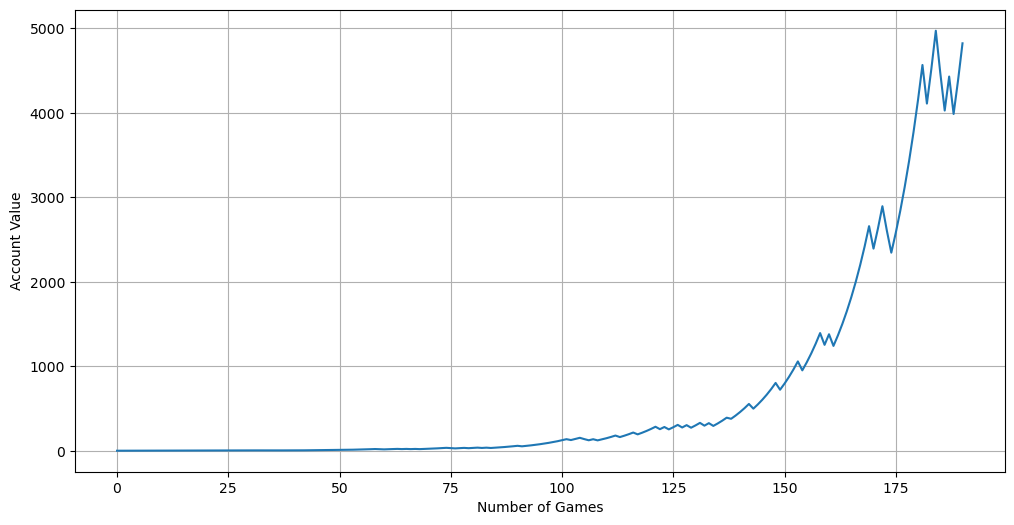

In [17]:
# best_params = study.best_trial.params
# Trial 121 finished with value: -1756081089942937.5 and parameters:
best_params = {'batch_size': 100, 'first_layer_size': 16, 'num_layers': 2, 'confidence_threshold': 0.03489120689273306, 'dropout': 0.29423607324535794, 'lr': 0.009613362543526419, 'n_epochs': 53}

model = objective(None, best_params)
probas = model.predict(perf_conts)
perf_y_col_tensor = torch.FloatTensor(perf_y_col).to(device)

performance_tensor = nfl_custom_criterion(probas, perf_y_col_tensor, 0.5, 0.1, True)


y_axis = torch.cumprod(performance_tensor, dim=0).numpy()
x_axis = np.arange(len(y_axis))

plt.figure(figsize=(12, 6))
plt.plot(x_axis, y_axis)
# plt.title(f'Backtest Results\nWin Rate: {win_rate:.2%} | ROI: {roi:.2%} | Max DD: {max_drawdown:.2%}')
plt.xlabel('Number of Games')
plt.ylabel('Account Value')
plt.grid(True)
plt.show()
# print(performance_tensor)

In [17]:
performance_tensor = nfl_custom_criterion(probas, perf_y_col_tensor, 0.5, 0.1, True)

print(performance_tensor)

tensor([0.9000, 1.0981, 0.9000, 0.9353, 1.0000, 1.0981, 1.0981, 1.0758, 1.0000,
        0.9000, 1.0825, 1.0981, 0.9332, 0.9358, 0.9000, 1.0000, 1.0064, 1.0981,
        1.0179, 1.0981, 1.0981, 1.0639, 1.0840, 0.9000, 1.0981, 1.0981, 1.0934,
        1.0782, 1.0000, 1.0981, 1.0448, 1.0981, 1.0981, 0.9000, 0.9470, 1.0500,
        0.9000, 0.9225, 0.9779, 1.0981, 1.0000, 1.0977, 1.0014, 1.0832, 1.0000,
        1.0000, 1.0670, 1.0319, 1.0981, 1.0981, 1.0981, 1.0981, 1.0981, 1.0981,
        1.0981, 0.9777, 1.0883, 1.0981, 1.0981, 0.9969, 0.9000, 1.0000, 1.0237,
        1.0094, 1.0665, 1.0569, 0.9310, 1.0656, 0.9110, 1.0981, 1.0981, 1.0981,
        1.0412, 1.0000, 1.0963, 0.9614, 0.9186, 1.0252, 1.0604, 0.9000, 1.0237,
        1.0000, 0.9000, 1.0981, 0.9000, 1.0981, 1.0000, 1.0157, 1.0807, 1.0408,
        1.0692, 0.9000, 1.0000, 1.0823, 1.0454, 1.0000, 1.0870, 1.0981, 1.0981,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0981, 1.0981, 1.0000, 0.9616, 1.0000,
        1.0000, 1.0981, 1.0981, 1.0981, 

[0.9        1.099894   0.9        1.099894   0.9        0.9
 1.099894   1.099894   1.099894   0.9        1.099894   1.099894
 1.099894   1.099894   0.9        1.099894   1.         1.099894
 1.0913885  1.099894   1.099894   1.099894   1.099894   1.099894
 1.099894   1.099894   1.099894   1.099894   0.92440385 1.099894
 1.099894   1.099894   1.099894   0.9        0.9        1.099894
 1.0952361  0.9        1.         1.099894   0.9        1.099894
 1.099894   1.099894   1.099894   0.9        1.099894   1.099894
 1.099894   1.099894   1.099894   1.099894   1.099894   1.099894
 1.099894   1.099894   1.099894   1.099894   1.099894   0.9
 0.9        1.099894   1.099894   1.099894   0.9        1.099894
 0.9        1.099894   0.9        1.099894   1.099894   1.099894
 1.099894   1.099894   1.099894   0.9        0.9        1.099894
 1.099894   0.9        1.099894   1.099894   0.9        1.099894
 0.9        1.099894   1.099894   1.099894   1.099894   1.099894
 1.099894   0.9        1.099894   1

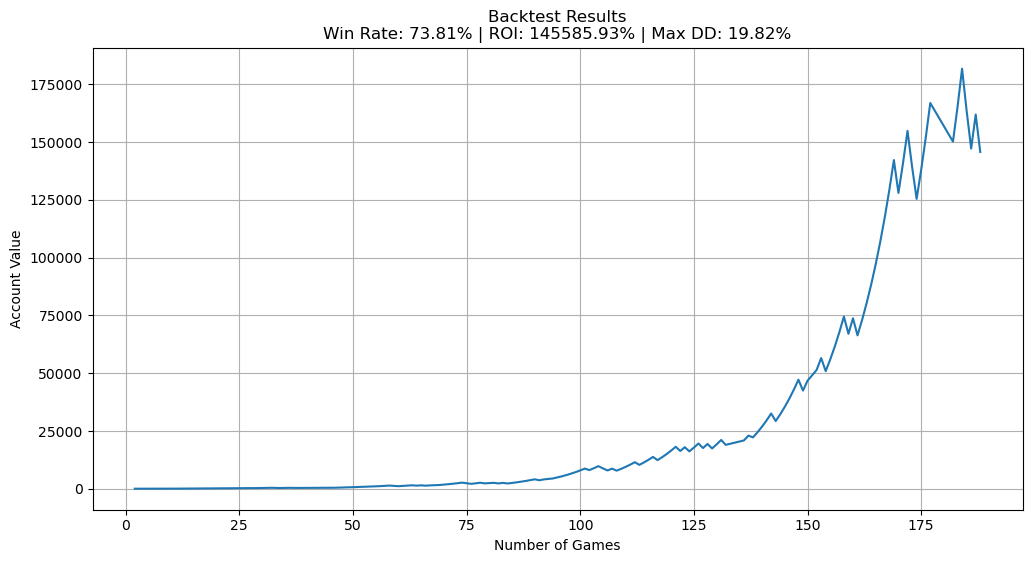

{'final_value': 145685.92536532413,
 'roi': 1455.8592536532412,
 'win_rate': 0.7380952380952381,
 'max_drawdown': 0.19817730361801306,
 'total_bets': 170}

In [18]:
performance_tensor = nfl_custom_criterion(probas, perf_y_col_tensor, 0.5, 0.1, True).numpy()
print(performance_tensor)
print(perf_date_col)
nfl_utils.backtest_model_custom_loss(performance_tensor, perf_date_col, initial_capital=100, show_plot=True)

['2024-10-14' 'BUF' 'NYJ']
2024-10-14: w_odds:1.36 acct_val: 1000.00 usable cash: 900.00 won: False
2024-10-14: w_odds:1.43 acct_val: 900.00 usable cash: 810.00 won: False
2024-10-14: w_odds:1.58 acct_val: 810.00 usable cash: 729.00 won: False
2024-10-14: w_odds:1.46 acct_val: 729.00 usable cash: 656.10 won: False
2024-10-14: w_odds:1.30 acct_val: 656.10 usable cash: 590.49 won: False
2024-10-14: w_odds:1.25 acct_val: 590.49 usable cash: 531.44 won: False
2024-10-14: w_odds:1.33 acct_val: 531.44 usable cash: 478.30 won: False
['2024-10-17' 'DEN' 'NOR']
2024-10-17: w_odds:1.83 acct_val: 478.30 usable cash: 430.47 won: False
['2024-10-20' 'PHI' 'NYG']
2024-10-20: w_odds:1.58 acct_val: 430.47 usable cash: 387.42 won: False
['2024-10-21' 'BAL' 'TAM']
2024-10-21: w_odds:1.58 acct_val: 387.42 usable cash: 348.68 won: False
2024-10-21: w_odds:1.94 acct_val: 348.68 usable cash: 313.81 won: False
2024-10-21: w_odds:1.12 acct_val: 313.81 usable cash: 282.43 won: False
2024-10-21: w_odds:1.58 acc

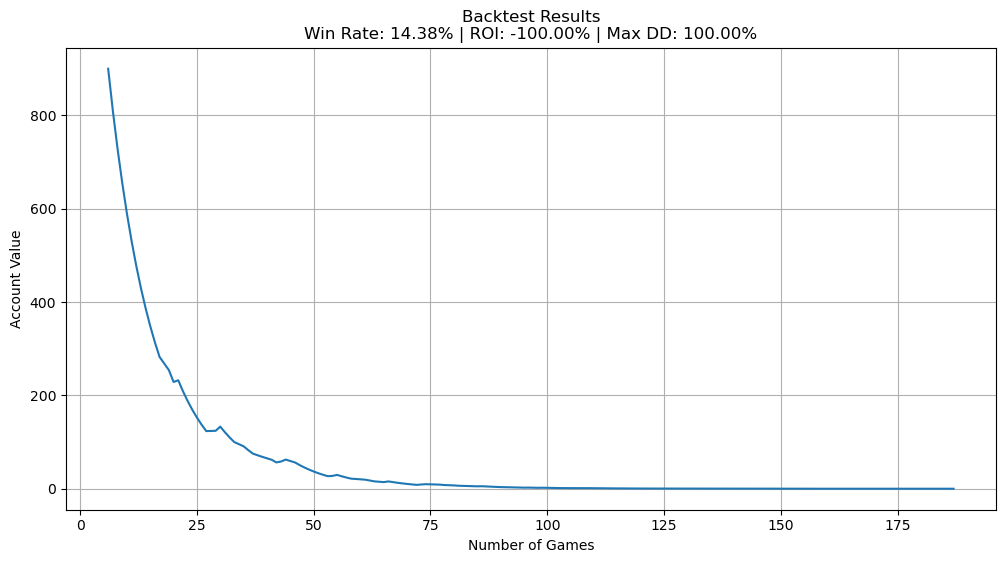

{'final_value': 0.005379082512624256,
 'roi': -0.9999946209174874,
 'win_rate': 0.1437908496732026,
 'max_drawdown': 0.9999946209174874,
 'total_bets': 153}

In [95]:
nfl_utils.backtest_model(model, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.1, 
                   confidence_threshold=0.0, show_plot=True, max_won_odds=2.2)

Value:  0.37491718013436764

Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 39
    dropout: 0.47875406200808335
    lr: 0.009997751942238913
    


Value:  0.3759073484440955
Params: 
    first_layer_size: 8
    num_layers: 2
    n_epochs: 68
    dropout: 0.4497689844977892
    lr: 0.007977206154472633
    
    
    
12/6

Trial 206 finished with value: 0.547218605316966 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 32, 'num_layers': 5, 'confidence_threshold': 0.05966702820817666, 'n_epochs': 379, 'dropout': 0.36961850006275193, 'lr': 0.008649806179332952}. Best is trial 206 with value: 0.547218605316966.

[I 2024-12-06 12:49:28,047] Trial 579 finished with value: 0.5335308702482566 and parameters: {'criterion': 'SmoothL1Loss', 'first_layer_size': 16, 'num_layers': 3, 'confidence_threshold': 0.059979796814548306, 'n_epochs': 481, 'dropout': 0.2511747953677191, 'lr': 0.007942836869449217}. Best is trial 579 with value: 0.5335308702482566.


[I 2024-12-06 14:53:00,850] Trial 385 finished with value: 0.5547767877242975 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 6, 'confidence_threshold': 0.003263372268063613, 'n_epochs': 300, 'dropout': 0.3153661030384182, 'lr': 0.00593138298730814}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:32:38,969] Trial 583 finished with value: 0.550872165273167 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.010458110701511005, 'n_epochs': 336, 'dropout': 0.3188974735143638, 'lr': 0.006976522077116529}. Best is trial 385 with value: 0.5547767877242975.

[I 2024-12-06 15:55:26,133] Trial 669 finished with value: 0.5645423555160363 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.0243907527056759, 'n_epochs': 370, 'dropout': 0.32998724447261185, 'lr': 0.0075018456671685696}. Best is trial 669 with value: 0.5645423555160363.

[I 2024-12-06 20:33:46,555] Trial 1737 finished with value: 0.5716002919237433 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.015368961704784596, 'n_epochs': 328, 'dropout': 0.348927921024466, 'lr': 0.009575624984802092}. Best is trial 1737 with value: 0.5716002919237433.


[I 2024-12-06 21:17:06,545] Trial 1889 finished with value: 0.5739803740995499 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 56, 'num_layers': 7, 'confidence_threshold': 0.014029751567812504, 'n_epochs': 357, 'dropout': 0.34275064196127053, 'lr': 0.008692336113071646}. Best is trial 1889 with value: 0.5739803740995499.

[I 2024-12-10 09:39:54,796] Trial 1612 finished with value: 0.5748324966932515 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 0.003855147984840053, 'dropout': 0.3182765851196762, 'lr': 0.008210651343970551, 'n_epochs': 219}. Best is trial 1612 with value: 0.5748324966932515.



Trial 1749 finished with value: 0.5772962775717783 and parameters: {'criterion': 'MSELoss', 'first_layer_size': 64, 'num_layers': 7, 'confidence_threshold': 1.8653941637231173e-05, 'dropout': 0.3181431308672629, 'lr': 0.009969598746996452, 'n_epochs': 231}.




['2024-02-11' 'SFO' 'KAN']
2024-02-11: w_odds:2.89 acct_val: 1000.00 usable cash: 900.00 won: False
['2024-10-10' 'SFO' 'SEA']
2024-10-10: w_odds:2.03 acct_val: 900.00 usable cash: 810.00 won: False
['2024-10-13' 'JAX' 'CHI']
2024-10-13: w_odds:1.46 acct_val: 810.00 usable cash: 729.00 won: False
['2024-10-14' 'BUF' 'NYJ']
2024-10-14: w_odds:1.99 acct_val: 729.00 usable cash: 656.10 won: False
2024-10-14: w_odds:1.36 acct_val: 656.10 usable cash: 590.49 won: False
2024-10-14: w_odds:1.43 acct_val: 590.49 usable cash: 531.44 won: True
2024-10-14: w_odds:1.58 acct_val: 615.80 usable cash: 469.86 won: True
2024-10-14: w_odds:1.46 acct_val: 651.67 usable cash: 404.69 won: False
2024-10-14: w_odds:1.30 acct_val: 586.50 usable cash: 346.04 won: True
2024-10-14: w_odds:1.25 acct_val: 604.00 usable cash: 285.64 won: False
2024-10-14: w_odds:1.33 acct_val: 543.60 usable cash: 231.29 won: True
['2024-10-17' 'DEN' 'NOR']
2024-10-17: w_odds:1.83 acct_val: 561.51 usable cash: 505.36 won: False
['20

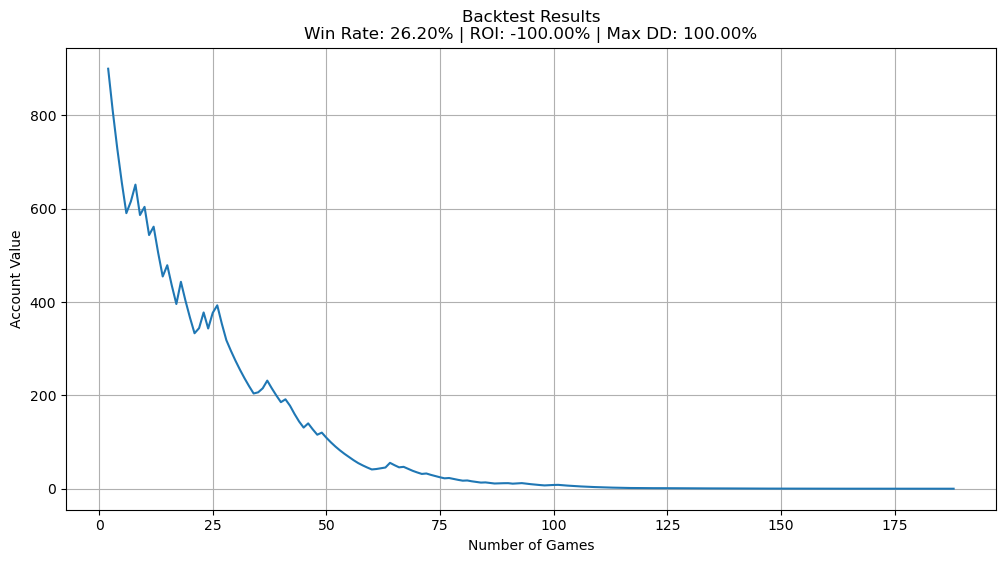

{'final_value': 0.015363152411150683,
 'roi': -0.9999846368475889,
 'win_rate': 0.2620320855614973,
 'max_drawdown': 0.9999846368475889,
 'total_bets': 187}

In [18]:
nfl_utils.backtest_model(pipeline, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.05, confidence_threshold=best_params['confidence_threshold'], show_plot=True)


In [19]:
# Remove outside of confidence threshold
mask = (probas < 0.5 - confidence_threshold) | (probas > 0.5 + confidence_threshold)
predictions = np.where(mask, probas, np.nan)

# Use numpy mask for nan values
valid_mask = ~np.isnan(predictions)
valid_predictions = predictions[valid_mask]
valid_mask = valid_mask.flatten()
perf_y_col_mask = perf_y_col[valid_mask]


true_values = perf_y_col_mask[:,0].astype(np.int32)
pred_values = valid_predictions.flatten()
pred_values_int = np.rint(valid_predictions).flatten().astype(np.int32)

model_win_prob = (1.0*(true_values == pred_values_int).sum()) / (true_values.shape[0])
print(model_win_prob)

0.25654450261780104


# Using XGBoost

In [20]:
conts_train.shape

(5264, 49)

In [ ]:
# Fit the model
param_grid = {
    'learning_rate': [ 0.008, 0.01, 0.03],           # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3, 6, 9],                      # Simplified to 3 values, covering shallow to deep
    'n_estimators': [100, 200],                  # Removed extremes, these are most common sweet spots
    'subsample': [0.8, 1.0],                     # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.8, 1.0],              # Same as above
    'min_child_weight': [1, 3],                  # Removed 5 as it might be too restrictive
}
aparam_grid = {
    'learning_rate': [0.005, 0.01, 0.05],        # Removed 0.5, 1 as they're often too aggressive
    'max_depth': [3],                         # Simplified to 3 values, covering shallow to deep
    'n_estimators': [300, 350, 400],             # Removed extremes, these are most common sweet spots
    'subsample': [0.5, 0.6, 0.7],                # Removed 0.6 as it might be too aggressive for this dataset size
    'colsample_bytree': [0.5, 0.6, 0.7],         # Same as above
    'min_child_weight': [3, 4],                  # Removed 5 as it might be too restrictive
}

# model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model = XGBRegressor(objective='reg:squarederror')

# Create a custom scorer using the F1 score
# f1_scorer = make_scorer(f1_score, average='weighted')
# Tune hyperparameters using GridSearchCV with the custom F1 scorer
# grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=5, verbose=1)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(conts_train, y_train)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
print(grid_search.best_params_)

In [ ]:

# train final model w/ early stopping
model = XGBClassifier(
    eval_metric='logloss',
    early_stopping_rounds=10,
    # **grid_search.best_params_,
    # **{'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # 66.5%, dd 31.4%
    # {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 0.8}
    # 66.5%, dd 30.9%
    # {'colsample_bytree': 1.0, 'learning_rate': 0.005, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.6}
)
model = XGBRegressor(
    objective='reg:squarederror', 
    # **grid_search.best_params_,
    # 67.3 w/ kelly adjustments 0.2, 0.01
    # {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 350, 'subsample': 0.6}
    # 67.2, dd 28.68 kelly 0.25, 0.014
    # **{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 350, 'subsample': 0.5}
    
   # **{'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.5}
    **{'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}


)
model.fit(
    conts_train,
    y_train,
    eval_set=[(conts_train, y_train)], # , (holdout_conts, holdout_y)
    verbose=True
)

In [ ]:
# perf_conts.shape
perf_y_col.shape
perf_y_col[0]

In [ ]:
# Make predictions for test data
# model = grid_search.best_estimator_
y_pred = model.predict(perf_conts)

nfl_utils.backtest_model(model, perf_conts, perf_y_col, perf_date_col, initial_capital=1000, position_size=0.1, 
                   confidence_threshold=0.0, show_plot=True, max_won_odds=2.2)

In [ ]:
# Make confusion matrix
cm = confusion_matrix(perf_y_col[:,0], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Save XGBoost model

In [ ]:
model.save_model('xgboost_model.bin')